# Apply PSO on Matching Network Optimization
From separate code on PSO and Matching Network, it's time to merge these 2 to make an optimization for MN

In [1]:
import time
start_time = time.time()
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf

----------------------------------------------------------
## I. Define Matching Network

Still, suppose I have a MN of 5 component like this:

*-------------L2-------------------C3---------------C1---------------*

     |          |             |             |
           
    Z_out      L1             C2             Z_load
           
     |          |             |             |
      
*---------------------------------------------------------------------*

and Z_load is not matched at 50Ohm, so with help from MN, I expect to get Z_out matched

Let's try to simplify the parallel or series type of a circuit

In [2]:
def parallel(Z1, Z2):
    return 1/(1/Z1 + 1/Z2)

def series(Z1, Z2): 
    return Z1 + Z2

Then, I assign type (R/L/C), connection orientation (ser/par), lowest and highest values of 5 components, respectively:

In [3]:
num_component = 3

component_type = ('L', 'C', 'L')
component_topology = ('par','ser', 'par')
range_C = (1e-12, 100e-12)
range_distance_C = range_C[1] - range_C[0]
range_L = (1e-9, 100e-9)
range_distance_L = range_L[1] - range_L[0]

And the function to calculate output impedance from Z load and MN

*note: for component type: 0 - C, 1 - L, 2 - R; for component placement: 0 - series, 1 - parallel*

In [4]:
def out_impedance(num_component, components, freq, Z_load):
    Z = np.zeros((num_component+1,),dtype = complex)
    Z_out = np.zeros((num_component+1,),dtype = complex)
    # calculate impedance of each component
    Z[0] = Z_load
    #print (Z[0],end = '   ')
    for i in range(num_component):
        if components[i][0] == 0: # C
            Z[i+1] = 1/(1j*2*np.pi*freq*components[i][2])
        elif components[i][0] == 1: # L
            Z[i+1] = 1j*2*np.pi*freq*components[i][2]
        else: # R
            Z[i+1] = components[i][2]
    # calculate result
    Z_out[0] = Z_load
    for i in range(num_component):
        if components[i][1] == 0: # series
            Z_out[i+1] = series(Z_out[i], Z[i+1])
        else:                     # parallel
            Z_out[i+1] = parallel(Z_out[i], Z[i+1])
        #print ('\n Zout', i+1,' :', Z_out[i+1])
    return Z_out[num_component]

---------------------------------------------
## II. Apply PSO
General parameters of PSO are defined here, meaning of them is *PSOsinc* notebook


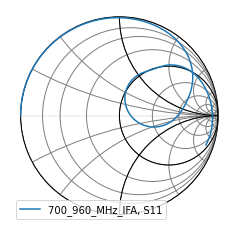

In [5]:
w = 0.3
c1 = 2
c2 = 2
max_iter = 30
freq = 1e+9
#Z_load = 20
Z0 = 50
ntwk = rf.Network('700_960_MHz_IFA.s1p')
ntwk.plot_s_smith()

### First step
Define the Solution Space

10 bees, or better-10 particles, will be assigned to the task to look for the best position in their so-called Solution Space. This space is 5D, as each agent needs 5 variables to define its location, seem unrealistic hah? :v

In [6]:
agent_quantity = 10
space_dimention = 3
agent_bound = np.zeros([num_component,2])
for i in range(space_dimention):
    if component_type[i] == 'C':
        agent_bound[i] = range_C
    else:
        agent_bound[i] = range_L
agent_bound

array([[1.e-09, 1.e-07],
       [1.e-12, 1.e-10],
       [1.e-09, 1.e-07]])

### Second step
Define a fitness function. In this case, it's the S11 at given frequency

In [7]:
def fitness(agent):
    fitness = 0
    components = np.zeros([num_component,3])
    for i in range(num_component):
        # Component type
        if component_type[i] == 'C':
            components[i][0] = 0 # C
        elif component_type[i] == 'L':
            components[i][0] = 1 # L
        else:
            components[i][0] = 1 # R
        # Component placement
        if component_topology[i] == 'ser':
            components[i][1] = 0
        else:
            components[i][1] = 1
        # Component value
        components[i][2] = agent[i]
        
    for i in range(350,451,1):
        Z_out = out_impedance(num_component, components, ntwk.frequency[i].center, ntwk.z[i][0][0])
        fitness += np.abs((Z_out - Z0)/(Z_out + Z0))
    return 1 - fitness/81
# Check fitness function
#fitness([10e-12, 20e-12, 30e-12, 40e-9, 50e-9])

### Third step 
Initialize Random Swam Location and Velocities

In [8]:
agent_location = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_location

array([[9.51424371e-08, 3.25987858e-11, 5.47175834e-09],
       [8.18625661e-08, 5.07911312e-11, 4.78165271e-08],
       [3.04880984e-09, 1.67764708e-11, 8.71516410e-08],
       [6.48129439e-08, 2.83679060e-11, 3.27998530e-08],
       [6.56959592e-08, 9.87115912e-12, 5.03161483e-08],
       [1.44993017e-09, 9.71381447e-11, 4.38633823e-08],
       [2.67563691e-08, 3.80857927e-11, 9.86827686e-08],
       [3.39751204e-08, 1.28325657e-11, 1.72881715e-08],
       [4.77510809e-08, 2.97621637e-11, 4.24684136e-08],
       [7.14438996e-08, 9.56126880e-11, 7.53553672e-08]])

*pbest at first is also the first swam*

In [9]:
agent_pbest = agent_location

In [10]:
agent_velocity = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_velocity

array([[7.75814483e-08, 8.53899912e-11, 9.67058452e-08],
       [8.50404467e-08, 4.00391103e-11, 7.10964556e-08],
       [2.71615370e-08, 8.75195924e-11, 9.63253074e-08],
       [5.25881597e-08, 9.15589242e-11, 4.24171638e-08],
       [8.48720918e-08, 8.99436491e-11, 1.58759498e-09],
       [2.37836189e-08, 2.68722183e-11, 2.49977642e-08],
       [1.51169613e-08, 5.17264195e-11, 8.23067278e-08],
       [1.27394521e-09, 4.57066549e-11, 5.26590326e-08],
       [6.10920253e-08, 1.04982649e-11, 5.93674467e-08],
       [4.00312145e-08, 8.11811609e-12, 8.94610413e-08]])

### Fourth step
Systematically Fly the Particles Through the Solution Space

a) Evaluate the Particles's Fitness, Compare to gbest, pbest

In [11]:
agent_fitness = np.zeros([agent_quantity,1])
pbest = np.zeros([agent_quantity,1])

for i in range(0,agent_quantity):
    agent_fitness[i] = fitness(agent_location[i])
    if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
pbest

array([[0.        ],
       [0.50421682],
       [0.        ],
       [0.47247062],
       [0.53927368],
       [0.        ],
       [0.47634295],
       [0.35728823],
       [0.48270627],
       [0.51666478]])

In [12]:
gbest = np.zeros(1)
gbest[0] = pbest.max()
gbest_position = pbest.argmax()
print('\n Global best', gbest[0])
print('\n Global best position', gbest_position)
print('\n Agent at best position', agent_pbest[gbest_position])


 Global best 0.5392736778900955

 Global best position 4

 Agent at best position [6.56959592e-08 9.87115912e-12 5.03161483e-08]


b) Update the Particle's velocity 

In [13]:
for i in range(agent_quantity):
    agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
agent_velocity

array([[ 1.90789720e-08,  2.23788205e-11,  3.54010730e-08],
       [ 2.55983626e-09, -4.60837836e-11,  2.48777364e-08],
       [ 1.18804425e-07,  1.40587717e-11, -3.61662931e-08],
       [ 1.63197418e-08,  1.60871608e-11,  2.35024220e-08],
       [ 2.54616275e-08,  2.69830947e-11,  4.76278495e-10],
       [ 1.72637753e-08, -5.69638654e-12,  8.51663826e-09],
       [ 2.04261098e-08,  4.00369708e-12,  4.95388039e-09],
       [ 3.93747383e-08,  1.00717142e-11,  5.63970522e-08],
       [ 2.60040466e-08, -5.35947121e-12,  2.11673288e-08],
       [ 7.78127902e-09, -6.06345481e-11,  8.41989683e-09]])

c) Move the particle

In [14]:
agent_location = agent_location + agent_velocity
for i in range(agent_quantity):
    for j in range(space_dimention):
        if agent_location[i][j] > agent_bound[j][1]:
            agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
        if agent_location[i][j] < agent_bound[j][0]:
            agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
        
agent_location

array([[8.57785908e-08, 5.49776063e-11, 4.08728314e-08],
       [8.44224024e-08, 4.70734760e-12, 7.26942635e-08],
       [7.81467653e-08, 3.08352425e-11, 5.09853479e-08],
       [8.11326858e-08, 4.44550668e-11, 5.63022750e-08],
       [9.11575867e-08, 3.68542538e-11, 5.07924268e-08],
       [1.87137054e-08, 9.14417582e-11, 5.23800206e-08],
       [4.71824790e-08, 4.20894898e-11, 9.63633510e-08],
       [7.33498587e-08, 2.29042799e-11, 7.36852236e-08],
       [7.37551276e-08, 2.44026925e-11, 6.36357424e-08],
       [7.92251786e-08, 3.49781399e-11, 8.37752641e-08]])

### Fifth step
Repeat everything in Step 4 untill iteration being out of range 

In [15]:
converge_flag = 0
for k in range(max_iter):
    if gbest[k] > 0.90:
        converge_flag = 1
        print('Converged!!! Hura!!')
        break
    # Step 4a
    for i in range(agent_quantity):
        agent_fitness[i] = fitness(agent_location[i])
        if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
    gbest = np.append(gbest, pbest.max())
    gbest_position = pbest.argmax()
    # Step 4b
    for i in range(agent_quantity):
        agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
    # Step 4c
    agent_location = agent_location + agent_velocity
    for i in range(agent_quantity):
        for j in range(space_dimention):
            if agent_location[i][j] > agent_bound[j][1]:
                agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
            if agent_location[i][j] < agent_bound[j][0]:
                agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
    #print('Iteration: ', k)
    #print('Gbest in this iteration: ', gbest)

if converge_flag == 0:
    k +=1 
print('\n Agent at best position', agent_pbest[gbest_position])            
print('Gbest value is ', gbest[k])


 Agent at best position [1.67381700e-08 2.92972646e-12 3.50465951e-08]
Gbest value is  0.7791348101294994


-----------------------------------------------------------
# III. Result
Final result is shown here, good or not, it've already taken a lot of time. Let's try to draw a graph to see the convergence progress

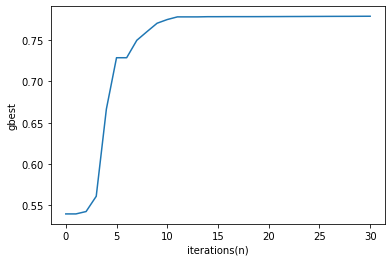

In [16]:
iterate = np.arange(k+1)
plt.plot(iterate,gbest)
plt.xlabel('iterations(n)')
plt.ylabel('gbest')
plt.show()

In [38]:
agent_gbest = agent_pbest[gbest_position]
components = np.zeros([num_component,3])
for i in range(num_component):
    # Component type
    if component_type[i] == 'C':
        components[i][0] = 0 # C
    elif component_type[i] == 'L':
        components[i][0] = 1 # L
    else:
        components[i][0] = 1 # R
    # Component placement
    if component_topology[i] == 'ser':
        components[i][1] = 0
    else:
        components[i][1] = 1
    # Component value
    components[i][2] = agent_gbest[i]
        
#print(components)
Z_out = np.zeros(1000, dtype=complex)
S11_out = np.zeros(1000)
f = np.arange(0.002,2.002,0.002)
for i in range(1,1000):
    Z_out[i] = out_impedance(num_component, components, ntwk.frequency[i].center, ntwk.z[i][0][0])
    S11_out = 20*np.log10(np.abs((Z_out - Z0)/(Z_out + Z0)))

S11 before matching:

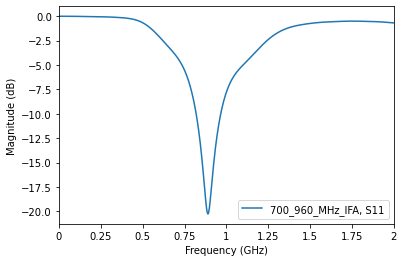

In [36]:
ntwk.plot_s_db()

S11 after matching:

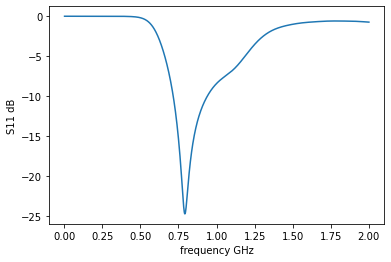

In [39]:
plt.plot(f,S11_out)
plt.xlabel('frequency GHz')
plt.ylabel('S11 dB')
plt.show()

*Oh Sh..t!! It takes to long for the calculation!

In [ ]:
print((round(time.time() - start_time),2), ' seconds!!!')